### Linear Models
- Linear Regression https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/readings/L02%20Linear%20Regression.pdf
- Don't worry about the maths, the focus is on identifying the key results and implimenting them programmatically
- This is not a linear algebra or calculus class, we will hack!!!

Write the regression problem in matrix form and then solve using normal equations. On the software side we will need to be able to have containers for 

- **Design Matrix: X**
- **parameters/weights: $\beta$** 
- **target variable: y**

This is a good time to introduce a numerical computing framework, numpy. This let's us do linear algebra operations which are key to many ML/DL tasks. Also provides us with abstractions that can help us impliment results straight out of a textbook. On the downside numpy matrices can't use gpu, hence while working with neural networks we will need frameworks that do linear algebra and can be use gpu acceleration

**What we need to code?**
- The raw data will be present in flat files, we need to read that
- Store them in to arrays
- Create y, $\beta$ and X
- Solve for $\beta$

In [1]:
import pandas as pd
data=pd.read_csv("data/regression.csv")

In [2]:
data.head(2)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0


In [3]:
y=data['mpg']
X=data[['cylinders','displacement']].copy()

In [4]:
X.head()

,cylinders,displacement
0,8.0,307.0
1,8.0,350.0
2,8.0,318.0
3,8.0,304.0
4,8.0,302.0


In [5]:
X['intercept']=1

In [6]:
X=X[['intercept','cylinders','displacement']]

In [7]:
X=X.values

In [8]:
y=y.values

Refer to the result 20, (https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/readings/L02%20Linear%20Regression.pdf), the parameters of the model are going to be:
$\beta=Inv((X^TX))X^Ty$

In [9]:
import numpy as np

In [10]:
def train(X,y):
    A=np.linalg.inv(np.matmul(np.transpose(X),X))
    B=np.matmul(np.transpose(X),y)
    return np.matmul(A,B)

In [11]:
train(X,y)

array([36.44476943, -0.51735734, -0.05225841])

What we have seen now is an example of closed form solution, very similar to saying that we have a formula to minimise the loss function. As we, progress further we will see that many times we may not be able to solve a loss minimization problem by finding a closed form solution. In such scenarios we can use a numerical procedure to calculate the minimum loss and the parameter values that result in such a loss value.

One of the commonly used techniques is called gradient descent. First let's understand how gradient descent works using an example of a simple example of a polynomial minimization

Assume I wanted to solve the following problem:
**$argmin_x f(x) = x^2+4x+18$**

The gradient descent algorithm works as below:
$X_{new} := X_{old}-\eta\frac{d(f(x)}{d(x)}$

In [12]:
def grad(x):
    return 2*x+4
def f(x):
    return x**2+4*x+18
X=0
eta=0.01
for i in range(5):
    gradient=grad(X)
    Xnew=X-eta*gradient
    X=Xnew
    func=f(X)
    print(f"Value of function is {func}, value of gradient is {gradient}, value of X is {X}")
    

Value of function is 17.8416, value of gradient is 4, value of X is -0.04
Value of function is 17.68947264, value of gradient is 3.92, value of X is -0.07919999999999999
Value of function is 17.543369523456, value of gradient is 3.8416, value of X is -0.117616
Value of function is 17.403052090327144, value of gradient is 3.764768, value of X is -0.15526368000000002
Value of function is 17.268291227550186, value of gradient is 3.68947264, value of X is -0.1921584064


In [13]:
class GradientDescent():
    def __init__(self,grad,f):
        self.grad=grad
        self.f=f
    def estimate(self,eta,n_iter,x_0):
        x=x_0
        for i in range(n_iter):
            gradient=self.grad(x)
            x_new=x-eta*gradient
            x=x_new
        result={'function_value':self.f(x),'parameter_value':x,'gradient_value':self.grad(x)}
        return result

In [14]:
gradient_descent=GradientDescent(grad,f)

In [15]:
gradient_descent.estimate(eta=0.01,n_iter=1000,x_0=0)

{'function_value': 14.0,
 'parameter_value': -1.9999999966340651,
 'gradient_value': 6.731869728326956e-09}

Let's apply gradient descent to solve the parameter estimation problem for linear regression, result 21 (https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/readings/L02%20Linear%20Regression.pdf) illustrates how this can be done:

Gradient of RSS=$X^T(XW-y)$
So, the update rule will be:
- $W_{new}=W_{old}-\eta X^T(XW_{old}-y)$

Clearly we will need to initialize the $W$ matrix, we will do this initially by making all the entries as zeros

In [16]:
class LinearRegression():
    def __init__(self,X,y):
        self.X=X
        self.y=y
        self.w=np.zeros((X.shape[1],))
    def _gradient(self,X,W,y):
        A=np.transpose(X)
        B=np.matmul(X,W)-y
        return np.matmul(A,B)
    def _fit(self,n_iter,eta):
        rss=[]
        grads=[]
        w=self.w
        for i in range(n_iter):
            iterations=i
            grad=self._gradient(self.X,w,self.y)
            w_new=w-(eta)*grad
            w=w_new
            rss.append(((np.matmul(X,w)-y)**2).mean())
            grads.append(grad)
            if i>2:
                if abs(rss[i]-rss[i-1])<0.00000001:
                    break
        results={'parameters':w}
        return results,rss,grads,iterations
    def fit(self,n_iter,eta):
        eta=np.array(eta)
        results,rss,grads,iterations=self._fit(n_iter,eta)
        self.results=results
        self.rss=rss
        self.grads=grads
        self.iter=iterations
        return results

In [17]:
X=data[['cylinders']].copy()
X['intercept']=1
X=X[['intercept','cylinders']]
X=X.values
y=data['mpg']
y=y.values

In [18]:
reg=LinearRegression(X,y)

In [19]:
reg.fit(n_iter=1000,eta=[0.001,0.0001])

{'parameters': array([42.94792539, -3.56264961])}

In [20]:
reg.iter

367

In [21]:
train(X,y)

array([42.9493135 , -3.56288658])

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

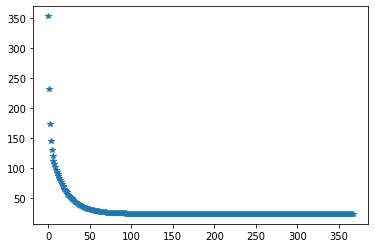

In [23]:
plt.plot(range(reg.iter+1),reg.rss,"*")

One can obtain predictions and get a sense of model performance by using the wights learnt

In [24]:
def predict_linear(X,w):
    return np.matmul(X,w)
preds=predict_linear(X,reg.fit(n_iter=1000,eta=[0.001,0.0001])['parameters'])

In [25]:
preds-y

array([ -3.55327152,  -0.55327152,  -3.55327152,  -1.55327152,
        -2.55327152,  -0.55327152,   0.44672848,   0.44672848,
         0.44672848,  -0.55327152,  -0.55327152,   0.44672848,
        -0.55327152,   0.44672848,   4.69732693,  -0.4279723 ,
         3.5720277 ,   0.5720277 ,   1.69732693,   2.69732693,
         3.69732693,   4.69732693,   3.69732693,   2.69732693,
         0.5720277 ,   4.44672848,   4.44672848,   3.44672848,
         5.44672848,   1.69732693,   0.69732693,   3.69732693,
         3.69732693,   2.5720277 ,   5.5720277 ,   4.5720277 ,
         2.5720277 ,   3.5720277 ,   0.44672848,   0.44672848,
         0.44672848,   0.44672848,   2.44672848,   1.44672848,
         1.44672848,   3.5720277 ,   6.69732693,   2.5720277 ,
         3.5720277 ,   5.69732693,   0.69732693,  -1.30267307,
        -1.30267307,  -2.30267307,  -6.30267307,   1.69732693,
         2.69732693,   4.69732693,   3.69732693,   5.69732693,
         8.69732693,   7.69732693,   1.44672848,   0.44

### Linear Classifier
- Undrestand log-loss (https://web.stanford.edu/~jurafsky/slp3/5.pdf)
- Build a simple class that can minimize log-loss for a linear classifier

The loss function of logistic regression is $-[ylog(p)+(1-y)log(1-p)]$, refer to result 5.9 (https://web.stanford.edu/~jurafsky/slp3/5.pdf)

The gradient for the loss function is: $X^T(P-y)=X^T(\sigma(XW)-y)$

Finally the gradient update will be:
- $W_{new}=W_{old}-\eta X^T(\sigma(XW)-y)$

In [26]:
class LogisticRegression():
    def __init__(self,X,y):
        self.X=X
        self.y=y
        self.w=np.zeros((self.X.shape[1],))
    def _gradient(self,X,w,y):
        z=np.matmul(X,w)
        sigma=1/(1+np.exp(-z))
        A=np.transpose(X)
        B=sigma-y
        return np.matmul(A,B)
    def loss(self,X,w,y):
        delta=0.000001
        z=np.matmul(X,w)
        p=1/(1+np.exp(-z))
        l=(-(np.log(p+delta)*y+(1-y)*np.log(1-p+delta))).mean()
        return l
    def _fit(self,n_iter,eta):
        logloss=[]
        w=self.w
        for i in range(n_iter):
            iterations=i
            grad=self._gradient(self.X,w,self.y)
            w_new=w-eta*grad
            w=w_new
            logloss.append(self.loss(self.X,w,self.y))
            if i>2:
                if abs(logloss[i]-logloss[i-1])<0.0000000001:
                    break
        results={'parameters':w}
        return results,iterations,logloss
    def fit(self,n_iter,eta):
        eta=np.array(eta)
        results,iterations,logloss=self._fit(n_iter,eta)
        self.iter=iterations
        self.logloss=logloss
        self.results=results
        return results

In [27]:
data=pd.read_csv("data/classification.csv")
data.head(2)

,No_pregnant,Plasma_glucose,Blood_pres,Skin_thick,Serum_insu,BMI,Diabetes_func,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


In [28]:
X=data[['No_pregnant']].copy()
X['intercept']=1
X=X[['intercept','No_pregnant']]
y=data['Class']
X=X.values
y=y.values

In [29]:
clf=LogisticRegression(X,y)

In [30]:
clf.fit(n_iter=1000,eta=[0.01,0.0001])

{'parameters': array([-1.17658058,  0.13716497])}

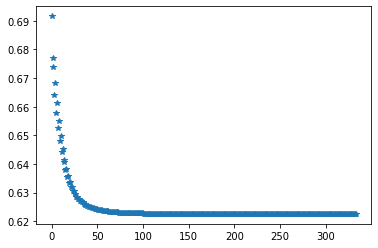

In [31]:
plt.plot(range(clf.iter+1),clf.logloss,"*")

Actual parameter estimates beta=-1.17675,beta1=0.13716 using a standard implimentation

Once we estimate parameters, of a model we may want to understand how good or bad a job we are doing at making predictions. We can get probability estimates from the model and try to find:
- Accuracy
- Confusion Matrix
- AUC

We will first create an inference function, we will use the computed weights and make preidctions

In [32]:
def predict(X,w):
    z=np.matmul(X,w)
    probs=1/(1+np.exp(-z))
    return probs
p=predict(X,clf.results['parameters'])

In [33]:
p_labels=pd.Series(p).map(lambda x:1 if x>0.5 else 0)
(p_labels.values==y).mean()

0.6640625

In [34]:
from sklearn.metrics import confusion_matrix,roc_auc_score
confusion_matrix(y,p_labels)

array([[462,  38],
       [220,  48]])

In [35]:
roc_auc_score(y,p)

0.6195149253731344

As far as linear classifiers are concerned, we may want to extend them to be able to do multiclass, classification. We can do this by making changes to the:
- Logistic Function, make it more generalizable
- Logitsic Cost Functon,make it more generalizable

Instead of using logistic function, we use softmax function to give probability score for each class (5.31, https://web.stanford.edu/~jurafsky/slp3/5.pdf ). To compute the loss, cross entropy loss is used (5.32, https://web.stanford.edu/~jurafsky/slp3/5.pdf)

The matrix formulation for this will be $X\times W$, where $X$ will be $r\times m$ and $W$ will be $m\times k$, where:
- r, number of rows in the predictor matrix
- m, number of predictors in the model
- k, number of classes

In [36]:
X=np.array([[1,0.2],[1,0.3],[1,0.4]])
y=np.array([0,1,2])

In [37]:
X

array([[1. , 0.2],
       [1. , 0.3],
       [1. , 0.4]])

In [38]:
def softmax(X,y):
    n_class=len(set(y))
    w=np.ones((X.shape[1],n_class))
    z=np.matmul(X,w)
    e_z=np.exp(z)
    return e_z/e_z.sum(axis=1,keepdims=True)

In [39]:
y

array([0, 1, 2])

In [40]:
softmax(X,y)[range(y.shape[0]),y]

array([0.33333333, 0.33333333, 0.33333333])

In [41]:
def cross_entropy(softmax,y):
    loss=-np.log(softmax[range(y.shape[0]),y])
    loss=np.sum(loss)/y.shape[0]
    return loss

In [42]:
cross_entropy(softmax(X,y),y)

1.0986122886681098